In [1]:
import pandas as pd
import numpy as np
import regex as re
import random
import scipy
from matplotlib import pyplot as plt

#specify path for data
path = r"00. Data\\train.csv"

In [2]:
#import credit sore classification dataset
df = pd.read_csv(path, low_memory=False)

In [3]:
#analyze dataset
df.shape

(100000, 28)

In [4]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.0,4194.170850,3183.686167,303.645417,1625.568229,3093.745000,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,17.091280,117.404834,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,100000.0,22.474430,129.057410,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,100000.0,72.466040,466.422621,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,98035.0,27.754251,193.177339,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,100000.0,32.285173,5.116875,20.000000,28.052567,32.305784,36.496663,50.000000
Total_EMI_per_month,100000.0,1403.118217,8306.041270,0.000000,30.306660,69.249473,161.224249,82331.000000


In [7]:
#basic data prep
df.columns = df.columns.str.lower()
df = df.set_index('customer_id')

#specify non-relevant columns/variables to drop
df.drop(columns=['id',
                 'name',
                 'ssn',
                 'month',
                 'type_of_loan',
                 'changed_credit_limit',
                 'amount_invested_monthly'],inplace=True)

In [8]:
#create helper functions to clean numeric columns
def clean_num(series):
    series = series.copy()

    if series.dtype == "object":
        series = series.apply(lambda x: re.sub(r"[^0-9.]","",str(x)))
        series.replace("",np.nan,inplace=True)
        series = series.astype(float)
        
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outlier_val = 1.5*IQR
    
    lower_bound = series.median() - outlier_val
    upper_bound = series.median() + outlier_val
    series[(series<lower_bound) | (series<0) | (series>upper_bound)] = np.nan
    

    series = series.fillna(series.groupby('customer_id').median())
    series.fillna(series.median(),inplace=True)
    
    return series


In [12]:
#create helper functions to clean string columns
def clean_string(series):
    df = series.copy().to_frame()
    df[series.name] = df[series.name].apply(lambda x: re.sub(r'[^a-zA-Z]+',"",str(x).strip()))
    df[series.name].replace("",np.nan,inplace=True) 
    grouped = df.groupby('customer_id')[series.name].agg(pd.Series.mode)
    grouped = grouped.apply(
        lambda x: x[round(random.uniform(0,1))] if type(x) == np.ndarray and len(x)>1 else x)
    df[series.name].fillna(grouped,inplace=True)
    global_mode = df[series.name].mode()[0]
    df[series.name] = df[series.name].apply(
        lambda x: global_mode if type(x) == np.ndarray and len(x)==0 else x)
    df = df.squeeze()

    return df

In [10]:
#manually fix credit_history_age column
df['credit_history_age'] = df['credit_history_age'].fillna('0 Years and 0 Months')
df['credit_history_age_months'] = df['credit_history_age'].apply(
    lambda x: np.dot([int(i) for i  in re.findall("[0-9]+",x)],[12,1]))
df['credit_history_age_months'].replace(0,np.nan,inplace=True)
df.drop(columns='credit_history_age',inplace=True)

In [13]:
#define variables to be numeric and string
col_float = ['age',
             'annual_income',
             'monthly_inhand_salary',
             'num_bank_accounts',
             'num_credit_card',
             'interest_rate',
             'num_of_loan',
             'delay_from_due_date',
             'credit_utilization_ratio',
             'total_emi_per_month',
             'monthly_balance',
             'num_credit_inquiries',
             'num_of_delayed_payment',
             'outstanding_debt',
             'credit_history_age_months',]  

col_string = ['credit_mix',
              'occupation',
              'payment_behaviour',
              'payment_of_min_amount']

In [14]:
#clean columns
for i in df.columns:

    if i in col_float:
        df[i] = clean_num(df[i])

    elif i in col_string:
        df[i] = clean_string(df[i])

df.drop_duplicates().reset_index().drop(columns='customer_id',inplace=True)

In [15]:
#reanalyze data to confirm desired cleaning/output (e.g., no nulls, no outstanding outliers, etc.)
df.shape

(100000, 20)

In [16]:
df.head()

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,payment_of_min_amount,total_emi_per_month,payment_behaviour,monthly_balance,credit_score,credit_history_age_months
customer_id,,,,,,,,,,,,,,,,,,,,
CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,4.0,Good,809.98,26.822620,No,49.574949,HighspentSmallvaluepayments,312.494089,Good,265.0
CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,6.5,4.0,Good,809.98,31.944960,No,49.574949,LowspentLargevaluepayments,284.629162,Good,268.5
CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,4.0,Good,809.98,28.609352,No,49.574949,LowspentMediumvaluepayments,331.209863,Good,267.0
CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,4.0,Good,809.98,31.377862,No,49.574949,LowspentSmallvaluepayments,223.451310,Good,268.0
CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,6.5,4.0,Good,809.98,24.797347,No,49.574949,HighspentMediumvaluepayments,341.489231,Good,269.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, CUS_0xd40 to CUS_0x942c
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   age                        100000 non-null  float64
 1   occupation                 100000 non-null  object 
 2   annual_income              100000 non-null  float64
 3   monthly_inhand_salary      100000 non-null  float64
 4   num_bank_accounts          100000 non-null  float64
 5   num_credit_card            100000 non-null  float64
 6   interest_rate              100000 non-null  float64
 7   num_of_loan                100000 non-null  float64
 8   delay_from_due_date        100000 non-null  float64
 9   num_of_delayed_payment     100000 non-null  float64
 10  num_credit_inquiries       100000 non-null  float64
 11  credit_mix                 100000 non-null  object 
 12  outstanding_debt           100000 non-null  float64
 13  credit_utilization_rat

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,33.311460,10.764730,14.000000,24.000000,33.000000,42.000000,56.000000
annual_income,100000.0,41981.498226,27294.747101,7005.930000,19342.972500,34499.780000,59992.420000,117566.960000
monthly_inhand_salary,100000.0,3461.988713,2237.448561,303.645417,1626.761667,2868.077500,4933.180417,9580.433333
num_bank_accounts,100000.0,5.368840,2.593273,0.000000,3.000000,5.000000,7.000000,11.000000
num_credit_card,100000.0,5.286330,1.797837,1.000000,4.000000,5.000000,7.000000,9.000000
interest_rate,100000.0,13.526560,7.706805,1.000000,7.000000,12.000000,19.000000,31.000000
num_of_loan,100000.0,3.532880,2.446356,0.000000,2.000000,3.000000,5.000000,9.000000
delay_from_due_date,100000.0,17.730400,10.409098,0.000000,10.000000,16.000000,25.000000,45.000000
num_of_delayed_payment,100000.0,13.381440,6.167148,1.000000,9.000000,14.000000,18.000000,27.000000
num_credit_inquiries,100000.0,5.743140,3.782696,0.000000,3.000000,5.000000,8.000000,15.000000


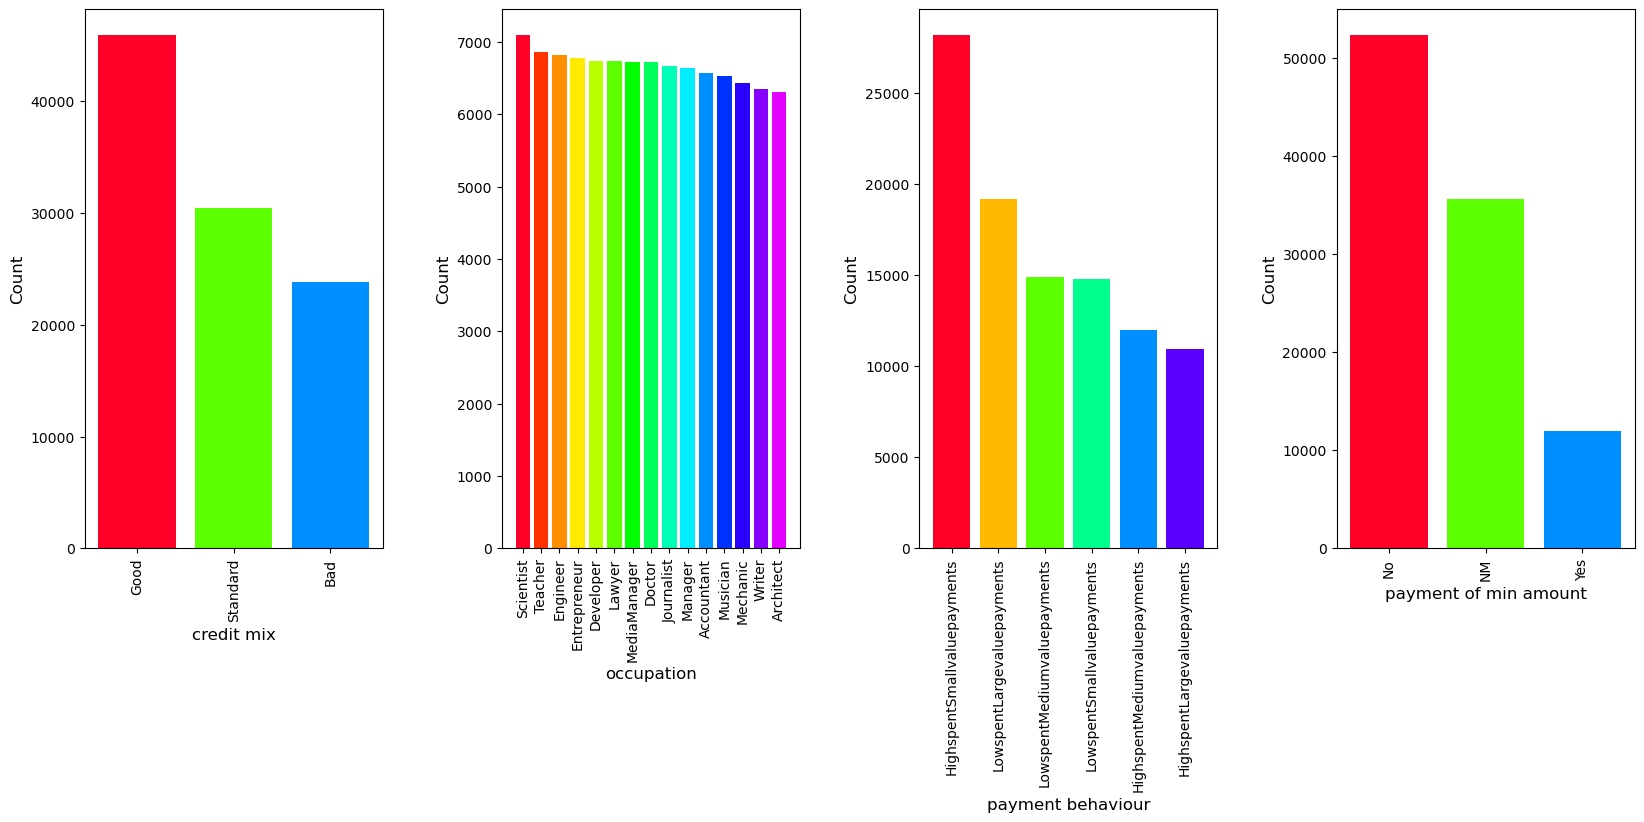

In [19]:
#Data visualization of categorical variables
fig, ax = plt.subplots(1, len(col_string),squeeze=False, figsize=(20,7))
cm = plt.get_cmap('gist_rainbow')

for i in range(len(col_string)):
    var = col_string[i]
    num_colors = len(df[var].value_counts())
    
    colors = [cm(1.*j/num_colors) for j in range(num_colors)]
    ax[0,i].bar(df[var].unique(), (df[var].value_counts()), color = colors)
    ax[0,i].tick_params(axis='x', labelrotation = 90)
    ax[0,i].set_xlabel(var.replace("_"," "), fontsize = 12)
    ax[0,i].set_ylabel("Count", fontsize = 12)
    
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.show()

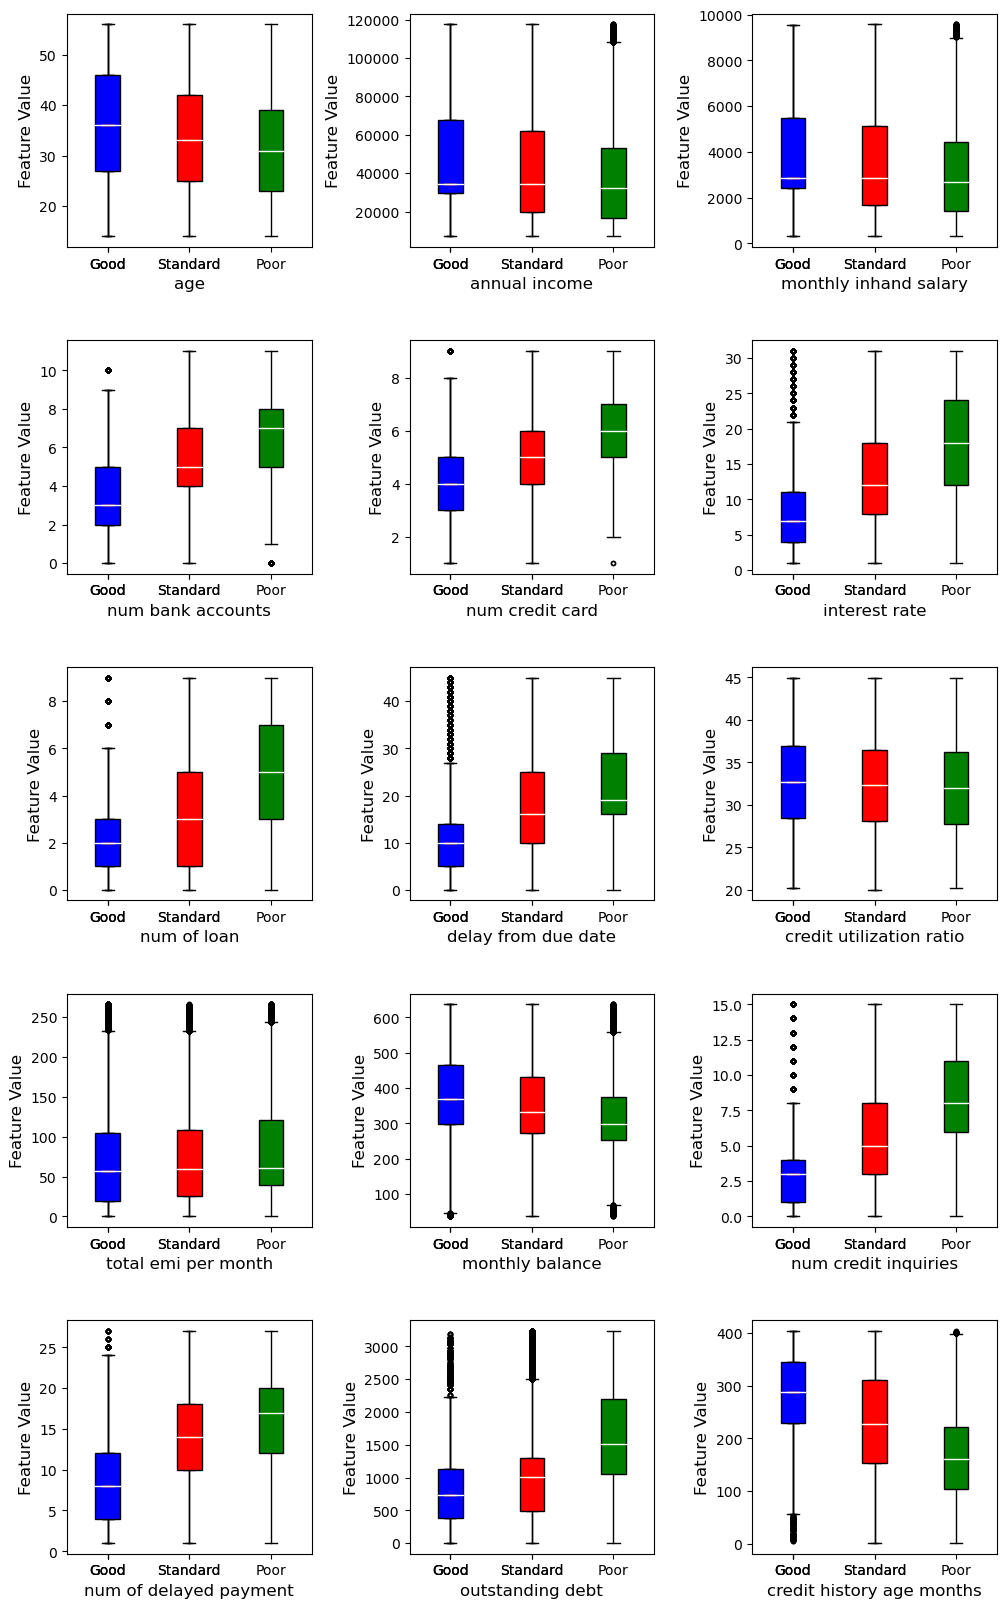

In [20]:
#data visualization (boxplots) for numeric variables
fig, ax = plt.subplots(5, 3, figsize = (12,20))
ax = ax.flatten()
colors = ['b', 'r', 'g']
for i in range(len(col_float)):
    boxplot_data = {}
    
    for credit_score in df['credit_score'].unique():
        boxplot_data[credit_score] = df[df['credit_score']==credit_score][[col_float[i]]].values.flatten()
        bp_dict = ax[i].boxplot(
            boxplot_data.values(), 
            labels=boxplot_data.keys(), 
            patch_artist=True, 
            flierprops = dict(marker = 'o',markersize = 3, linestyle = 'none'), whis = 1.5)
        
    bp_dict['boxes'][0].set_facecolor(colors[0])
    bp_dict['boxes'][1].set_facecolor(colors[1])
    bp_dict['boxes'][2].set_facecolor(colors[2])

    bp_dict['medians'][0].set_color('white')
    bp_dict['medians'][1].set_color('white')
    bp_dict['medians'][2].set_color('white')
    
    ax[i].set_xlabel(col_float[i].replace("_"," "), fontsize = 12)
    ax[i].set_ylabel('Feature Value',fontsize = 12)
    ax[i].grid(color = 'white', linestyle = '-', linewidth = 2, alpha = 0.5)

fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
plt.show()

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

random_state = 10

In [22]:
#normalize numeric variables
scaler = MinMaxScaler()
for i in df[col_float]:
    df[i] = scaler.fit_transform(df[[i]])

In [23]:
#creating dummies for categorical variables
for i in col_string:
    df = pd.get_dummies(df, prefix = i, columns = [i], drop_first = False)

In [24]:
#create test, train sets
df_train_x = df.drop(columns='credit_score')
df_train_y = df['credit_score']
x_train, x_test, y_train, y_test = train_test_split(df_train_x,df_train_y,test_size=0.20,random_state=random_state)

Accuracy:  0.75095
Classification Report 
               precision    recall  f1-score   support

        Good       0.70      0.69      0.69      3512
        Poor       0.75      0.74      0.75      5836
    Standard       0.77      0.77      0.77     10652

    accuracy                           0.75     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.75      0.75      0.75     20000



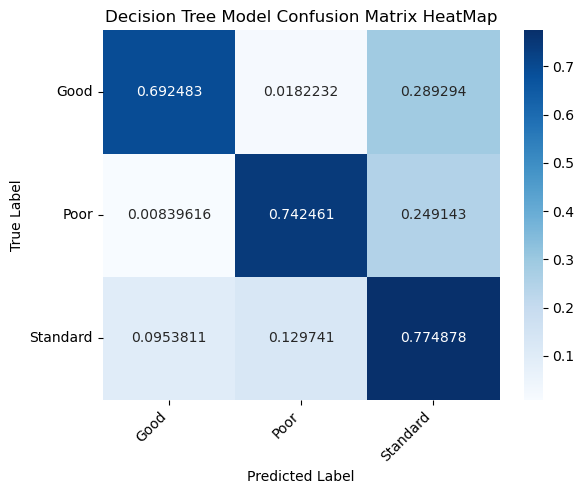

In [25]:
obs_map = {1: "Poor", 2: "Standard", 0: "Good"}

#decision tree modelling and results
dtree = DecisionTreeClassifier(random_state = random_state)
dtree = dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred)).rename(index = obs_map, columns = obs_map)
cm = (cm.T/cm.sum(axis=1)).T
accuracy = accuracy_score(y_test, y_pred)
dtree_report = classification_report(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification Report \n", dtree_report)

plt.figure()
heatmap = sns.heatmap(cm, annot=True, cmap = "Blues", fmt = 'g')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Decision Tree Model Confusion Matrix HeatMap')
plt.show()                            

Accuracy:  0.69555
Classification Report 
               precision    recall  f1-score   support

        Good       0.60      0.61      0.61      3512
        Poor       0.69      0.65      0.67      5836
    Standard       0.73      0.75      0.74     10652

    accuracy                           0.70     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.70      0.70      0.70     20000



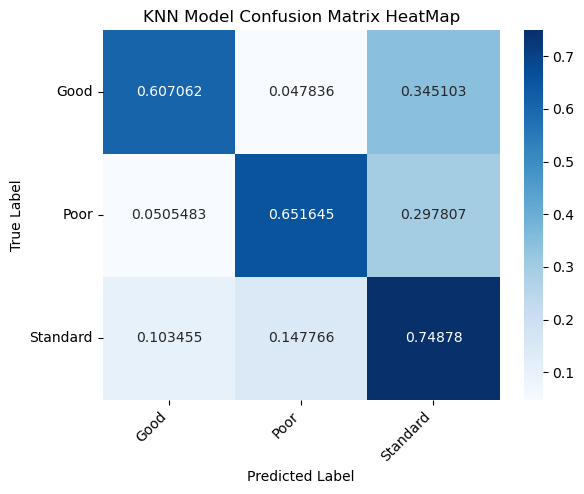

In [26]:
#KNN modelling and results
kn = KNeighborsClassifier(n_neighbors=5,weights = 'distance')
kn.fit(x_train, y_train)
kn_y_pred = kn.predict(x_test)

kn_cm = pd.DataFrame(confusion_matrix(y_test,kn_y_pred)).rename(index = obs_map, columns = obs_map)
kn_cm = (kn_cm.T/kn_cm.sum(axis=1)).T
kn_accuracy = accuracy_score(y_test,kn_y_pred)
kn_report = classification_report(y_test,kn_y_pred)

print("Accuracy: ", kn_accuracy)
print("Classification Report \n", kn_report)

plt.figure()
heatmap = sns.heatmap(kn_cm, annot=True, cmap = "Blues", fmt = 'g')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('KNN Model Confusion Matrix HeatMap')
plt.show()         


Accuracy:  0.81445
Classification Report 
               precision    recall  f1-score   support

        Good       0.78      0.77      0.78      3512
        Poor       0.80      0.84      0.82      5836
    Standard       0.83      0.82      0.83     10652

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



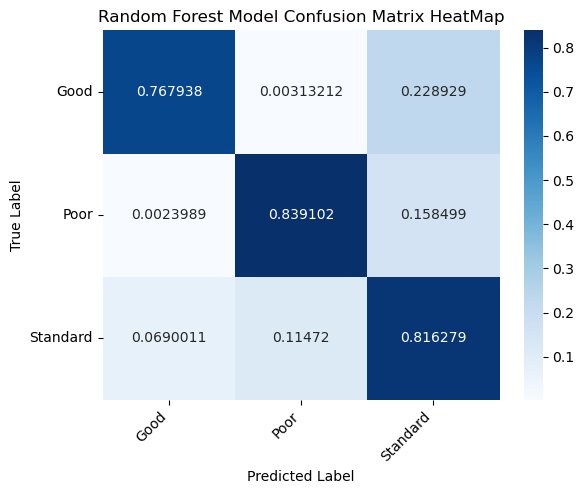

In [27]:
#Random Forest modelling and results
rf = RandomForestClassifier(n_estimators=100, random_state = random_state)
rf.fit(x_train,y_train)
rf_y_pred = rf.predict(x_test)

rf_cm = pd.DataFrame(confusion_matrix(y_test,rf_y_pred)).rename(index = obs_map, columns = obs_map)
rf_cm = (rf_cm.T/rf_cm.sum(axis=1)).T
rf_accuracy = accuracy_score(y_test,rf_y_pred)
rf_report = classification_report(y_test,rf_y_pred)

print("Accuracy: ", rf_accuracy)
print("Classification Report \n", rf_report)

plt.figure()
heatmap = sns.heatmap(rf_cm, annot=True, cmap = "Blues", fmt = 'g')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Random Forest Model Confusion Matrix HeatMap')
plt.show()         